<a href="https://www.kaggle.com/code/jaymanvirk/fine-tuning-logreg-rf-nb-svm-and-xgboost?scriptVersionId=146555550" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Spooky Author Identification: Fine-tuning Logistic Regression, Random Forest, Multinomial Naive Bayes, SVM and XGBoost

**Jay Manvirk (Ivan Loginov)**<br/>
University of Colorado, Boulder<br/>
jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#chapter_1)
2. [Introduction](#chapter_2)
3. [Libraries and raw data](#chapter_3)
    - 3.1 [Libraries](#chapter_3_1)
    - 3.2 [Raw data](#chapter_3_2)
4. [Exploratory data analysis](#chapter_4)
    - 4.1 [Short datasets summary](#chapter_4_1)
    - 4.2 [Number of records per author](#chapter_4_2)
    - 4.3 [Word frequencies per author](#chapter_4_3)
5. [Data preprocessing](#chapter_5)
    - 5.1 [Text cleaning](#chapter_5_1)
    - 5.2 [TF-IDF vectorization](#chapter_5_2)
    - 5.3 [Dimensionality reduction](#chapter_5_3)
    - 5.4 [Standardization](#chapter_5_4)
    - 5.5 [Label encoding](#chapter_5_5)
6. [Model architecture](#chapter_6)
    - 6.1 [Logistic Regression](#chapter_6_1)
    - 6.2 [Random Forest](#chapter_6_2)
    - 6.3 [Multinomial Naive Bayes](#chapter_6_3)
    - 6.4 [SVM](#chapter_6_4)
    - 6.5 [XGBoost](#chapter_6_5)
7. [Model results](#chapter_7)
8. [Submission results](#chapter_8)
9. [Conclusion](#chapter_9)
10. [References](#chapter_10)

# 1. Abstract <a class="anchor" id="chapter_1"></a>

In this study we explore the fine-tuning of various machine learning algorithms: Logistic Regression, Random Forest, Multinomial Naive Bayes, Support Vector Machine (SVM) and XGBoost, for the task of author classification based on short textual excerpts. Our objective is to identify the optimal configurations that minimize logloss.

All the experiments conducted in this study were based on the dataset comprising text from works of fiction written by renowned authors of the public domain: Edgar Allan Poe, H.P. Lovecraft and Mary Shelley. Every algorithm undergoes fine-tuning via grid search and cross-validation within limited computational resources, ensuring a detailed exploration of the hyperparameter space.

# 2. Introduction <a class="anchor" id="chapter_2"></a>

This study aims to optimize several machine learning algorithms:
* Logistic Regression
* Random Forest
* Multinomial Naive Bayes
* SVM
* XGBoost.

under moderate computational constraints. The goal is to identify configurations that minimize log loss in the author classification problem while ensuring computational efficiency.

The dataset is sourced from Kaggle for both training and submission purposes and can be accessed by following the link in the References section. It consists of:
* trainig data: 19 579 texts
* testing data: 8 392 texts
* unique authors: 3 (Edgar Allan Poe, Howard P. Lovecraft, Mary W. Shelley)
* text language: English
* training text average size: ~149 characters
* testing text average size: ~148 characters

To attain our objective, we will navigate through the following sections:
* **Exploratory data analysis:**<br/>
Short dasets summary: examining the dataset's size, structure, and the average length of text will guide us in determining whether further parallelization of computations is necessary.<br/>
Number of records per author: understanding the distribution of records per author provides helps identify the need for techniques such as down/up-sampling and additional class balancing tuning in our models<br/>
Word frequencies per author: this analysis enables us to identify noise in the data which might hinder the accuracy of our models
* **Data preprocessing:**<br/>
Text cleaning: based on the insights from EDA, we'll eliminate words that don't contribute useful information about the author's style<br/>
TF-IDF vectorization: we'll convert texts into a word-weight matrix using TF-IDF for later use in the model training to achieve lower log loss<br/>
Standardization: we'll introduce transformation of our word-weights to a consistent range to see whether this method enhances the convergence speed of gradient-based optimizers<br/>
Label encoding: as raw string labels cannot be processed by some algorithms, we will encode them into integers
* **Model architecture:**<br/>
In this section, we will introduce configurations for Logistic Regression, Random Forest, Multinomial Naive Bayes, SVM, and XGBoost. The provided selection of hyperparameters will be utilized by GridSearchCV to identify the best set for our models.
* **Model results:**<br/>
We will present a summarizing table displaying the model results, including every specified set of parameters from the previous section. Additionally, we will provide explanations for these results, offering insights into our model performance.

# 3. Libraries and data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [60]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from concurrent.futures import ProcessPoolExecutor
from sklearn.decomposition import TruncatedSVD

# Model architecture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [94]:
# Print list of files and directories in folder
list_l = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        list_l.append(os.path.join(dirname, filename))
list_l

['/kaggle/input/spooky-author-identification/train.zip',
 '/kaggle/input/spooky-author-identification/test.zip',
 '/kaggle/input/spooky-author-identification/sample_submission.zip']

In [95]:
# Set datasets
train_data = pd.read_csv(list_l[0])
test_data = pd.read_csv(list_l[1])
sample_data = pd.read_csv(list_l[2])

In [96]:
# Cleaning
del list_l

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

The dataset includes 3 unique authors (categories):
* EAP, Edgar Allan Poe
* HPL, Howard Phillips Lovecraft
* MWS, Mary Wollstonecraft Shelley

The memory usage of datasets is measured in kilobytes. The approximate numbers are:
* training data: 459 kB
* testing data: 131 kB
* sample data: 262.4 kB

In [5]:
def print_short_summary(name, data):
    """
    Print data head, shape and info.
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2 Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()
    if 'text' in data.columns:
        avg = np.mean(np.vectorize(len)(data['text']))
        print('\n4. Average number of characters per text: {:.0f}'.format(avg))

In [6]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL

2 Data shape: (19579, 3)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB

4. Average number of characters per text: 149


In [7]:
print_short_summary('Test data', test_data)

Test data

1. Data head:
        id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2  id00134  And when they had broken down the frail door t...
3  id27757  While I was thinking how I should possibly man...
4  id04081  I am not sure to what limit his knowledge may ...

2 Data shape: (8392, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8392 non-null   object
 1   text    8392 non-null   object
dtypes: object(2)
memory usage: 131.2+ KB

4. Average number of characters per text: 148


In [8]:
print_short_summary('Sample data', sample_data)

Sample data

1. Data head:
        id       EAP       HPL       MWS
0  id02310  0.403494  0.287808  0.308698
1  id24541  0.403494  0.287808  0.308698
2  id00134  0.403494  0.287808  0.308698
3  id27757  0.403494  0.287808  0.308698
4  id04081  0.403494  0.287808  0.308698

2 Data shape: (8392, 4)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8392 non-null   object 
 1   EAP     8392 non-null   float64
 2   HPL     8392 non-null   float64
 3   MWS     8392 non-null   float64
dtypes: float64(3), object(1)
memory usage: 262.4+ KB


In [9]:
# Cleaning
del print_short_summary

## 4.2 Number of records per author <a class="anchor" id="chapter_4_2"></a>

The dataset shows a slight imbalance in the number of texts per author. However, additional down/up-sampling is unnecessary for two reasons:
1. Information loss when downsampling: removed samples can contain unique author's style which model wouldn't be able to catch
2. Overfitting when upsampling: with added replicated samples model starts memorizing the duplicated examples instead of learning the underlying patterns

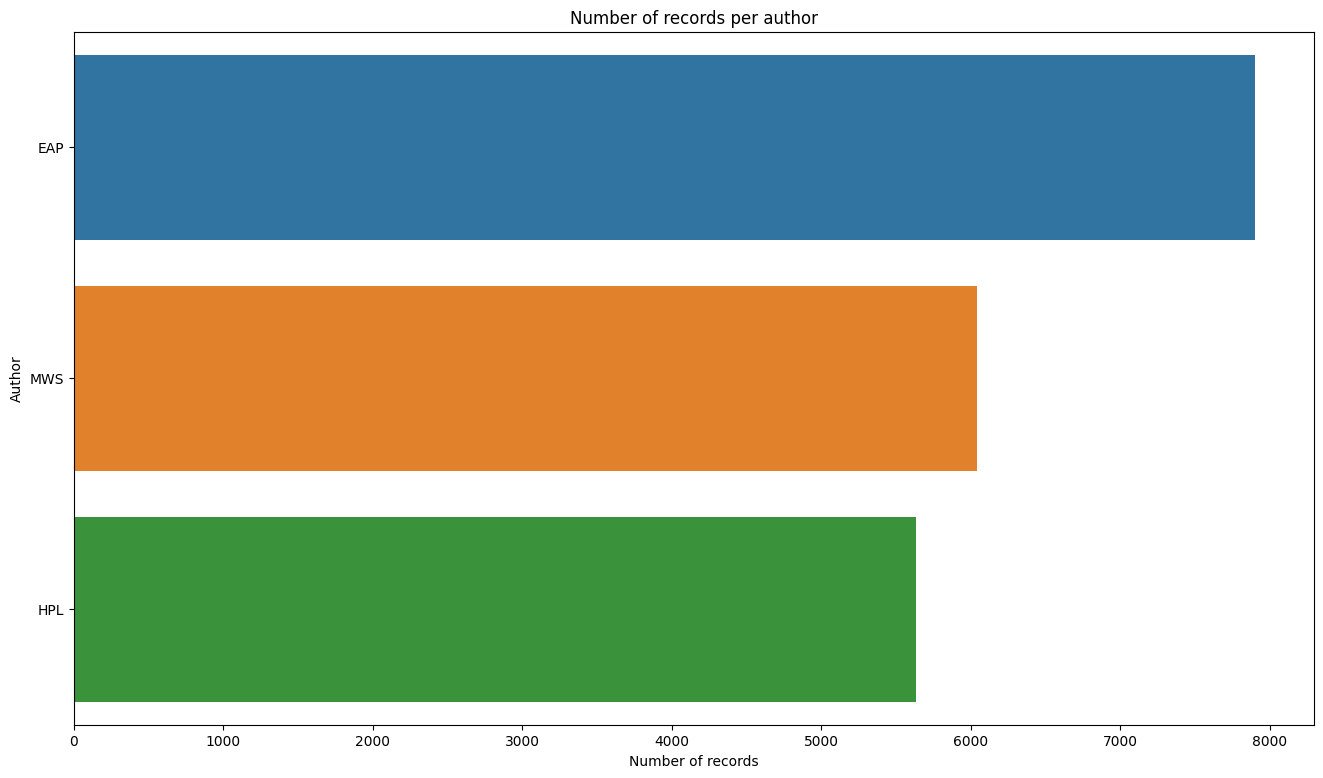

In [10]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data['author'].value_counts()
sns.barplot(y=tmp.index.values, x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Author')
plt.title('Number of records per author')
plt.show()

In [11]:
# Cleaning
del tmp

## 4.3 Word frequencies per author <a class="anchor" id="chapter_4_3"></a>

From the initial set of charts, it becomes evident that prepositions, articles, and pronouns dominate the frequency distribution. This dominance poses a challenge for the subsequent models as texts across authors share a similar pattern of short word usage. Considering these words as noise, we aim to eliminate this interference to provide models a better understanding of each author's unique word usage.

In [12]:
def plot_word_dist_author(labels, top_n_words = 10):
    """
    Plot charts with word frequencies per author
    Args:
        labels: list of authors
        top_n_words (opt): how many top words to plot in one chart
    """
    n = len(labels)
    
    # Get default seaborn's palette to match colours with the previous chart
    default_palette = sns.color_palette("deep")
    
    # Initialize subplots with 1 row and n columns
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(16, 9))
    
    # Plot word count per author in the respective rows
    for i in range(n):
        col = i % n
        indexes = train_data['author'] == labels[i]
        w = train_data['text'][indexes].str.split(expand=True).unstack().value_counts()
        l = w[:top_n_words]/np.sum(w)*100
        axes[col].bar(l.index, l.values, color=default_palette[i])
        axes[col].set_title(labels[i])
        axes[col].set_xlabel('Words')
        axes[col].set_ylabel('Percentage of total word count (%)')

    plt.tight_layout()
    plt.show()

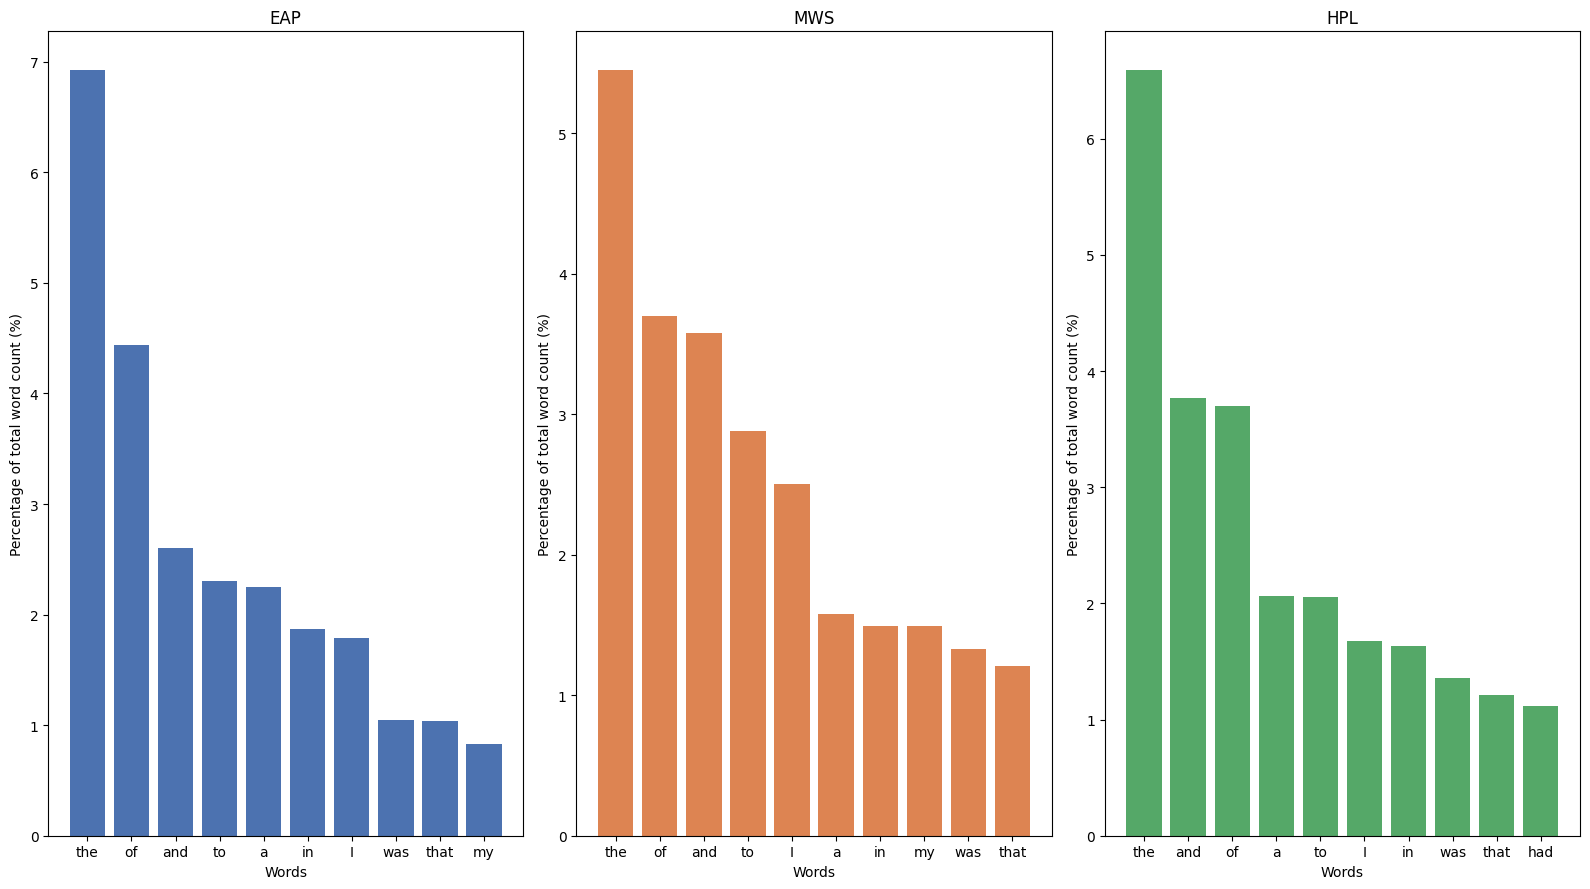

In [13]:
# Plot word frequencies by author
plot_word_dist_author(['EAP', 'MWS', 'HPL'])

In [14]:
# Cleaning
del plot_word_dist_author

# 5. Data preprocessing <a class="anchor" id="chapter_5"></a>

## 5.1 Text cleaning <a class="anchor" id="chapter_5_1"></a>

Cleaning text via lemmatization, removing single-letter words, stopwords and digits reduces noise and irrelevant information. It should help models focus on important patterns and make training more efficient.

In [15]:
# Load english lemmas
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Compile regex pattern
pattern = re.compile(r'\b([a-zA-Z])\b|\d+|[.,!?()-:;]')

# Set english stopwords such as "the", "of", "and", "to" etc.
stop_words = set(stopwords.words('english'))

In [16]:
def get_processed_text(text):
    """
    Return lemmatized text without single letters and digits.
    Everything is in the lower case register.
    Args:
        text (str): text of an article
    Returns:
        text (str): cleand text
    """
    # Convert to lowercase and remove digits, single letters
    text = pattern.sub('', text.lower())
    
    # Get lemma tokens
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]

    # Join the words back into a string
    text = ' '.join(lemmas)
    
    return text

def get_clean_text(texts):
    """
    Return cleaned text.
    Execution in parallel.
    
    Args:
        texts: numpy array of string elements
    Returns:
        clean_texts: numpy array of cleaned string elements
    """
    # Set up parallel tasks processing 
    with ProcessPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))
        
    return np.array(clean_texts)

In [17]:
# Get cleaned train and test texts
train_clean_data = get_clean_text(train_data['text'].values)
test_clean_data = get_clean_text(test_data['text'].values)

In [18]:
# Print an example of the cleaned text
train_clean_data[0]

'process however afford mean ascertain dimension dungeon   might make circuit return point whence   set without aware fact perfectly uniform seem wall'

In [19]:
# Cleaning
del spacy_process, pattern, stop_words
del get_clean_text, get_processed_text

## 5.2 TF-IDF vectorization <a class="anchor" id="chapter_5_2"></a>

When the TfidfVectorizer is applied to raw text, it converts the text data into a matrix of TF-IDF features. Specifically, the output is a sparse matrix representing the TF-IDF weights of the words in the input text.

* sublinear_tf = True: this scaling often produces better results
* ngram_range = (1, 2): with both unigrams and bigrams TF-IDF can capture more context and potentially improve the model's understanding of the text

In [20]:
# Create vectorizer to convert plain text into feature matrix
vectorizer = TfidfVectorizer(sublinear_tf = True
                             , ngram_range = (1,2)
                             )
tfidf_vect = vectorizer.fit(train_clean_data)

In [21]:
# Set training and testing data for the upcoming models
X_train_tfidf = tfidf_vect.transform(train_clean_data)
X_test_tfidf = tfidf_vect.transform(test_clean_data)

In [22]:
del vectorizer, test_data, train_clean_data, test_clean_data

## 5.3 Dimensionality reduction <a class="anchor" id="chapter_5_3"></a>

With TruncatedSVD we transform the TF-IDF matrix into a lower-dimensional representation. In doing so we aim to capture key information from the TF-IDF features.
* n_components = 100: this is an arbitrary choice which allows the model training process faster without significant increase in its logloss

In [23]:
# Reduce dimensionality of TF-IDF matrices
svd = TruncatedSVD(n_components=100)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

## 5.4 Standardization <a class="anchor" id="chapter_5_4"></a>

Since we're going to work with Logistic Regression, SVM, XGBoost, which use gradient descent for optimization, the standardization can be a good step in the data preprocessing. Standardizing TF-IDF features can help these models converge faster and might improve performance.

Multinomial Naive Bayes and Random Forest are generally not affected by feature scales, thus no improvement in the final results is expected.

In order to fine-tune models in the next section we're going to use both standardized and non-standardized features in order to get the best scores under selected constraints.
* with_mean = False: this setting preserves sparsity in text data, avoiding non-zero values and memory inefficiency caused by centering around the mean

In [42]:
# Standardize features without centering
scaler = StandardScaler(with_mean = False)
X_train_stand = scaler.fit_transform(X_train_tfidf)
X_test_stand = scaler.fit_transform(X_test_tfidf)

X_train_stand_svd = scaler.fit_transform(X_train_svd)
X_test_stand_svd = scaler.fit_transform(X_test_svd)

In [43]:
# Cleaning
del scaler

## 5.5 Label encoding <a class="anchor" id="chapter_5_5"></a>

Label encoding works better in model training because it converts categorical labels into numerical representations, allowing algorithms to process them mathematically.

In [102]:
# Encode labels using OneHotEncoder
dict_map = {'EAP':0, 'MWS':1, 'HPL':2}
y_train = train_data['author'].map(dict_map).values

In [28]:
# Cleaning
del label_encoder, train_data

# 6. Model architecture <a class="anchor" id="chapter_6"></a>

In this section we present 5 models tailored for notebook efficiency, all of which are generally considered to have decent predictive accuracy:
* **Logistic Regression:**<br/>
Simple, interpretable and efficient with sparse text data.
* **Random Forest:**<br/>
Handles non-linear relationships, robust to overfitting and capable of capturing complex patterns in text data.
* **Multinomial Naive Bayes:**<br/>
Extremely fast, efficient and works well with high-dimensional, sparse data.
* **SVM:**<br/>
Effective in handling non-linearity through kernels.
* **XGBoost:**<br/>
Generally considered efficient and accurate with robust regularization techniques.

## 6.1 Logistic Regression <a class="anchor" id="chapter_6_1"></a>

* class_weight = balanced: since we have slightly imbalanced dataset this setting helps the algorithm give more importance to minority class samples during training
* C: inverse of regularization strength
* solver: optimization algorithm used during training

In [75]:
# Set config for GridSearchCV
config_logreg = {
    'model': LogisticRegression()
    , 'name': 'Log Reg'
    , 'param_grid':
    {
        'class_weight': ['balanced']
        , 'C': [0.5, 1.0, 1.5]
        , 'solver': ['saga', 'lbfgs']
    }
}

## 6.2 Random Forest <a class="anchor" id="chapter_6_2"></a>

* n_estimators: higher number of trees can improve the model's accuracy, but it also increases computational cost
* max_depth: higher value leads to capture more complex patterns in the data, but may also result in overfitting

In [74]:
# Set config for GridSearchCV
config_rf = {
    'model': RandomForestClassifier()
    , 'name': 'Random Forest'
    , 'param_grid':
    {
        'n_estimators': [50, 75, 100]
        , 'max_depth': [10, 20]
    }
}

## 6.3 Multinomial Naive Bayes <a class="anchor" id="chapter_6_3"></a>

* alpha: smoothing parameter that prevents zero probabilities in the computation, smalller values lead to underfitting, higher values - overfitting

In [83]:
# Set config for GridSearchCV
config_nb = {
    'model': MultinomialNB()
    , 'name': 'Mult NB'
    , 'param_grid':
    {
        'alpha': [0.001, 0.01, 0.1, 0.2, 0.4]
    }
}

## 6.4 SVM <a class="anchor" id="chapter_6_4"></a>

* class_weight = balanced: the same setting as in the Logistic Regression with similar reasoning
* probability = True: allows the model to predict class probabilities which is useful in our case to calculate logloss
* max_iter = 100: determines the maximum number of iterations taken for the solvers to converge
* C: smaller values create a wider-margin decision boundary, potentially improving generalization, larger - fitting the training data more closely
* kernel: function to transform the input data

In [71]:
# Set config for GridSearchCV
config_svm = {
    'model': SVC()
    , 'name': 'SVM'
    , 'param_grid':
    {
        'class_weight': ['balanced']
        , 'probability': [True]
        , 'max_iter': [100]
        , 'C': [0.5, 1.0, 1.5]
        , 'kernel': ['rbf', 'sigmoid']
    }
}

## 6.5 XGBoost <a class="anchor" id="chapter_6_5"></a>

* objective = 'multi:softmax': this setting ensures that the algorithm is optimized for predicting one of the n labels, which is 3 in our case
* num_class = 3: number of unique authors
* eval_metric = mlogloss: multi logloss, the specified metric used in a competition based on this dataset
* n_estimators = 100: specifies the maximum number of boosting rounds
* eta: learning rate, controls the step size shrinkage used in each boosting iteration
* max_depth: the maximum depth of each tree in the boosting process

In [72]:
# Set config for GridSearchCV
config_xgb = {
    'model': xgb.XGBClassifier()
    , 'name': 'XGBoost'
    , 'param_grid':
    {
        'objective': ['multi:softmax']
        , 'num_class': [3]
        , 'eval_metric': ['mlogloss']
        , 'n_estimators': [100]
        , 'eta': [0.2, 0.3, 0.4]
        , 'max_depth': [5, 7]
    }
}

# 7. Model results <a class="anchor" id="chapter_7"></a>

Multinomial Naive Bayes stands out among our chosen models due to its handling of input data. It simply cannot process negative inputs. Therefore we opted for TF-IDF and standardized TF-IDF values for this model, since these inputs remain non-negative in contrast to the output of TruncatedSVD.

The final rankings are presented with model configurations sorted in ascending order based on their test logloss and runtime values. The following list showcases the models, starting from the best to worst performance:
1. **Multinomial Naive Bayes:**<br/>
Multinomial Naive Bayes excelled with the top performance observed at alpha = 0.01. Notably, its success was attributed to using non-standardized input, preserving raw frequency information essential for word count features. Standardization disrupted these patterns, hindering this model performance and scoring the last in the rankings.
2. **XGBoost:**<br/>
Although XGBoost secured the second position, it lagged behind notably in both logloss and runtime compared to the top performer. Intriguingly, standardizing the data had minimal impact on the algorithm's efficiency, highlighting its resilience to variations in input scaling. Adjusting the maximum number of rounds might have enhanced its performance, but it would have resulted in a significantly longer computation time.
3. **Logistic Regression:**<br/>
Though Logistic Regression scored higher logloss than XGBoost, it completely outperformed it terms of runtime. Despite its logloss being only marginally higher, this model processed results in a mere 0.4 seconds, a stark contrast to the 165 seconds of XGBoost. Due to its simplicity additional parameter tuning can further enhance its speed, but not necessarily translate into better scores.
4. **Random Forest:**<br/>
Random Forest models performed surprisingly poor with worse runtime and train/test scores. While being generally robust additional feature engineering or hyperparameter tuning might have improved the model's speed and accuracy.
5. **SVM:**<br/>
These set of models though resulted the last in test logloss, were twice as fast as Random Forest. However this speed advantage did not translate into improved accuracy, as their logloss exceeded 1. This indicates that the models might need more nuanced tuning, since they're very sensitive to the supoptimal choices.

Examining the selected models based on the disparity between their train and test scores, Logistic Regression and SVM stood out with better generalization. In contrast, other algorithms displayed noticeable signs of overfitting.

In [34]:
def get_grid(config_model, X_train, y_train):
    """
    Return grid of GridSearchCV results from selected models and their parameters.
    Execution in parallel.
    
    Args:
        config_model (dict): dictionary of model's parameters
        X_train (ndarray): data to train
        y_train (ndarray): data labels
    Returns:
        dict: a dictionary with the results from training via GridSeachCV
    """
    # GridSearchCV utilizes all available CPU cores with n_jobs = -1.
    grid = GridSearchCV(config_model['model']
                        , config_model['param_grid']
                        , return_train_score = True
                        , scoring = 'neg_log_loss'
                        , cv = 5
                        , n_jobs = -1)

    # Fit object to training data
    grid = grid.fit(X_train, y_train)
        

    return grid


def get_model_results(model_name, grid_results, data_standardized):
    """
    Return a dictionary of model results.
    
    Args:
        model_name (str): name of a model
        grid_results (dict): GridSearchCV dictionary of model results
        data_standardized (1 or 0): data is stadardized
    Returns:
        dict: dictionary with updated columns
    """
    runtime = grid_results['mean_fit_time'] + grid_results['mean_score_time']
    model_results = {
        'model': model_name
        , 'params': grid_results['params']
        , 'data_std': data_standardized
        , 'mean_runtime (sec)': runtime
        , 'mean_train_score (logloss)': -grid_results['mean_train_score']
        , 'mean_test_score (logloss)': -grid_results['mean_test_score']
    }
    
    return model_results

def get_table_results_sorted(list_dict):
    """
    Convert list of dictionaries and sort by mean_test_score and mean_runtime.
    
    Args:
        list_dict (list): list of dictionaries from GridSearchCV
    Returns:
        DataFrame: sorted dataframe by mean_test_score and mean_runtime
    """
    table = [pd.DataFrame(results) for results in list_dict]   
    table = pd.concat(table)
    table = table.sort_values(by = ['mean_test_score (logloss)'
                                  ,'mean_runtime (sec)']
                        , ascending = [True, True])
    
    return table

def get_final_table_results(config_models, config_data):
    """
    Return table with every trained model and its results from GridSearchCV.
    
    Args:
        config_models (list): list of model configurations
        confg_data (list): list of data configurations
    Returns:
        DataFrame: sorted dataframe by mean_test_score and mean_runtime
    """
    n = len(config_models)
    m = len(config_data)
    table = []
    for i in range(n):
        for j in range(m):
            print('model: {} of {} | data: {} of {}'.format(i+1,n,j+1,m))
            grid = get_grid(config_models[i], config_data[j], y_train)
            model_results = get_model_results(config_models[i]['name']
                                              , grid.cv_results_
                                             , j)
            table.append(model_results)
    
    table = get_table_results_sorted(table)

    return table

In [ ]:
# Create table of Multinomial Naive Bayes results
table_nb = get_final_table_results([config_nb], [X_train_tfidf, X_train_stand])

In [120]:
# Set list of models except Mult NB and non/standardized X_train
config_models = [config_logreg, config_rf, config_svm, config_xgb]
config_data = [X_train_svd, X_train_stand_svd]

In [ ]:
# Get table of every model except Mult NB
table_results = get_final_table_results(config_models, config_data)

In [ ]:
# Concatenate tables and print final rankings
table_results = get_table_results_sorted([table_results, table_nb])

In [132]:
# Print results table
table_results.reset_index(drop=True)

,model,params,data_std,mean_runtime (sec),mean_train_score (logloss),mean_test_score (logloss)
0,Mult NB,{'alpha': 0.01},0,0.099190,0.007060,0.452783
1,Mult NB,{'alpha': 0.001},0,0.108816,0.005063,0.476987
2,Mult NB,{'alpha': 0.1},0,0.101461,0.040156,0.523184
3,Mult NB,{'alpha': 0.2},0,0.090844,0.097879,0.577759
4,Mult NB,{'alpha': 0.4},0,0.084410,0.218241,0.648070
5,XGBoost,"{'eta': 0.2, 'eval_metric': 'mlogloss', 'max_d...",0,164.587107,0.404302,0.744850
6,XGBoost,"{'eta': 0.2, 'eval_metric': 'mlogloss', 'max_d...",1,165.384545,0.404302,0.744850
7,XGBoost,"{'eta': 0.3, 'eval_metric': 'mlogloss', 'max_d...",0,164.089526,0.308546,0.749213
8,XGBoost,"{'eta': 0.3, 'eval_metric': 'mlogloss', 'max_d...",1,164.793355,0.308546,0.749213
9,XGBoost,"{'eta': 0.2, 'eval_metric': 'mlogloss', 'max_d...",0,235.362629,0.128991,0.760204


In [ ]:
# Cleaning
del config_models, config_data, table_results, table_nb
del get_grid, get_model_results, get_table_results_sorted, get_final_table_results

# 8. Submission results <a class="anchor" id="chapter_8"></a>

### Public score: 0.41209

In [123]:
# Fit top performance model
model = MultinomialNB(alpha = 0.01).fit(X_train_tfidf, y_train)

In [124]:
# Get predicted probabilities of classes
results = model.predict_proba(X_test_tfidf)

In [125]:
# Create submission talbe
table_submis = pd.DataFrame(results, columns=['EAP', 'MWS', 'HPL'])
table_submis['id'] = sample_data['id']

In [126]:
# Print submission table
table_submis[['id','EAP','HPL','MWS']]

,id,EAP,HPL,MWS
0,id02310,0.082737,0.012839,0.904424
1,id24541,0.981698,0.005675,0.012627
2,id00134,0.175292,0.818827,0.005881
3,id27757,0.973328,0.026642,0.000030
4,id04081,0.838934,0.092796,0.068270
...,...,...,...,...
8387,id11749,0.589244,0.085558,0.325198
8388,id10526,0.089651,0.082103,0.828247
8389,id13477,0.999920,0.000039,0.000041
8390,id13761,0.127073,0.003818,0.869110


In [127]:
# Make submission
table_submis.to_csv('submission.csv', index=False)

In [ ]:
# Cleaning
del model, results, table_submis

# 9. Conclusion <a class="anchor" id="chapter_9"></a>

In this study, five distinct models were tested within constrained computational resources, leading to the following insights:

1. **Logistic Regression:**<br/>
Slightly higher logloss than XGBoost but excelled in runtime due to its simplicity. Further parameter tuning could enhance speed however doesn't guarantee improved scores.
2. **Random Forest:**<br/>
Performed below expectations, suggesting potential gains through feature engineering or hyperparameter adjustments for better speed and accuracy.
3. **Multinomial Naive Bayes:**<br/>
Excelled at alpha = 0.01, leveraging non-standardized input. Standardization disrupted patterns, resulting in the lowest ranking.
4. **SVM:**<br/>
Despite being twice as fast as Random Forest, its speed advantage did not boost accuracy. Nuanced tuning is essential, given the models' sensitivity to suboptimal choices.
5. **XGBoost:**<br/>
Secured the second position, demonstrating resilience to input scaling variations. Adjusting rounds might improve performance, albeit at the cost of increased computation time.

Additionally, considering the disparity between train and test scores, Logistic Regression and SVM exhibited superior generalization. In contrast, other models displayed prominent signs of overfitting. These findings underscore the delicate balance between model complexity, efficiency, and accuracy, highlighting areas for further optimization.

# 10. References <a class="anchor" id="chapter_10"></a>

* Meg Risdal, Rachael Tatman. (2017). Spooky Author Identification. Kaggle.<br/>
https://kaggle.com/competitions/spooky-author-identification
* BBC News Classification: Matrix Factorization vs Supervised Learning<br/>
https://www.kaggle.com/code/jaymanvirk/matrix-factorization-nmf-vs-supervised-learning
* Scikit-learn Supervised learning<br/>
https://scikit-learn.org/stable/supervised_learning.html
* XGBoost Parameters<br/>
https://xgboost.readthedocs.io/en/stable/parameter.html
* Launching parallel tasks<br/>
https://docs.python.org/3/library/concurrent.futures.html